<a href="https://colab.research.google.com/github/apester/PINN/blob/main/PINN_Compare_Euler_CN_Exact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN vs Numerical Schemes vs Exact Series — 1D Advection–Diffusion (Dirichlet)

This Colab-ready notebook compares a trained **PINN** against:

1) **Euler (explicit)**: upwind advection + central diffusion (very small `dt` needed)  
2) **IMEX CN+Upwind**: Crank–Nicolson diffusion + explicit upwind advection (tridiagonal solve each step)  
3) **Exact (“closed-form”) series solution** (Fourier series; convergent and effectively exact when truncated)

All methods use the **same physical problem**:

\[
c_t + u c_x = D c_{xx},\qquad x\in(0,L),\ t\in[0,T].
\]

**Given (fixed):**
- \(L=2\), \(N=1000\Rightarrow \Delta x=0.002\)
- \(u=1\), \(D=\tfrac12\)
- IC: \(c(x,0)=x\)
- Dirichlet BCs: \(c(0,t)=0\), \(c(L,t)=L=2\)

You can **either load** a pre-trained PINN checkpoint **or train** one inside this notebook.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from dataclasses import dataclass

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## 1) Parameters (same grid/inputs for all comparisons)

In [2]:
@dataclass
class Params:
    L: float = 2.0
    N: int = 1000
    u: float = 1.0
    D: float = 0.5
    T: float = 0.10

    # Reporting times (we compare at these times)
    report_dt: float = 0.01

    # CN(IMEX) time step (CFL controls explicit advection)
    dt_cn: float = 1e-3

    # Euler explicit time step (diffusion stability forces dt ~ O(dx^2))
    dt_euler: float = 2e-6

    # Exact series truncation
    n_modes_exact: int = 2000

    # PINN training defaults (if you choose to train here)
    n_f: int = 20000
    n_ic: int = 2000
    n_bc: int = 2000
    n_data: int = 8000
    epochs: int = 3000
    lr: float = 1e-3
    print_every: int = 200

p = Params()

dx = p.L / p.N
x_grid = np.linspace(0.0, p.L, p.N + 1)
t_report = np.arange(0.0, p.T + 1e-12, p.report_dt)

print("dx =", dx)
print("x_grid shape:", x_grid.shape)
print("t_report:", t_report)
print("CFL(CN step) = u*dt_cn/dx =", p.u * p.dt_cn / dx)
print("Euler mu = D*dt_euler/dx^2 =", p.D * p.dt_euler / dx**2)


dx = 0.002
x_grid shape: (1001,)
t_report: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
CFL(CN step) = u*dt_cn/dx = 0.5
Euler mu = D*dt_euler/dx^2 = 0.25


## 2) Exact series solution (reference)

In [3]:
def c_exact_series(x, t, L=2.0, u=1.0, D=0.5, n_modes=2000):
    """Exact solution as a Fourier series (truncated)."""
    x = np.asarray(x, dtype=float).reshape(-1)
    a = u / (2.0 * D)
    exp_ax = np.exp(a * x)

    n = np.arange(1, n_modes + 1, dtype=float)
    beta = n * np.pi / L
    alpha = D * beta**2 + (u**2) / (4.0 * D)

    exp_aL = np.exp(-a * L)
    term = 1.0 - ((-1.0) ** n) * exp_aL

    F = -(2.0 * u / L) * (beta * term) / (a**2 + beta**2)
    b_n = (F / alpha) * (1.0 - np.exp(-alpha * t))

    sin_bx = np.sin(beta[:, None] * x[None, :])
    series = (b_n[:, None] * sin_bx).sum(axis=0)

    return x + exp_ax * series

C_exact = np.vstack([c_exact_series(x_grid, tt, L=p.L, u=p.u, D=p.D, n_modes=p.n_modes_exact) for tt in t_report])
C_exact.shape


(11, 1001)

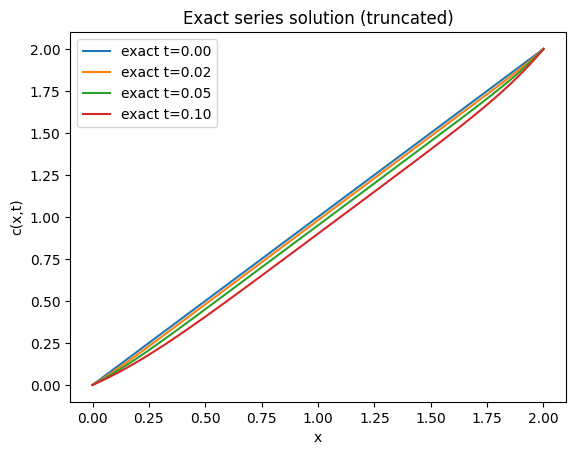

In [4]:
plt.figure()
for tt in [0.0, 0.02, 0.05, 0.1]:
    idx = int(round(tt / p.report_dt))
    plt.plot(x_grid, C_exact[idx], label=f"exact t={t_report[idx]:.2f}")
plt.xlabel("x"); plt.ylabel("c(x,t)"); plt.legend()
plt.title("Exact series solution (truncated)")
plt.show()


## 3) Numerical solvers: CN(IMEX) and Euler

In [5]:
def thomas_solve(a, b, c, d):
    m = len(b)
    cp = np.empty(m - 1)
    dp = np.empty(m)

    denom = b[0]
    cp[0] = c[0] / denom
    dp[0] = d[0] / denom

    for i in range(1, m - 1):
        denom = b[i] - a[i - 1] * cp[i - 1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i - 1] * dp[i - 1]) / denom

    denom = b[m - 1] - a[m - 2] * cp[m - 2]
    dp[m - 1] = (d[m - 1] - a[m - 2] * dp[m - 2]) / denom

    x = np.empty(m)
    x[m - 1] = dp[m - 1]
    for i in range(m - 2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i + 1]
    return x


def solve_imex_cn_upwind(L, N, u, D, T, dt):
    dx = L / N
    Nt = int(round(T / dt))
    t = np.linspace(0.0, Nt * dt, Nt + 1)
    x = np.linspace(0.0, L, N + 1)

    C = np.zeros((Nt + 1, N + 1), dtype=float)
    C[0, :] = x
    C[:, 0] = 0.0
    C[:, -1] = L

    lam = u * dt / dx
    mu = D * dt / dx**2

    m = N - 1
    a = (-mu / 2.0) * np.ones(m - 1)
    b = (1.0 + mu) * np.ones(m)
    c = (-mu / 2.0) * np.ones(m - 1)

    for n in range(Nt):
        if u >= 0:
            A = lam * (C[n, 1:N] - C[n, 0:N-1])
        else:
            A = lam * (C[n, 2:N+1] - C[n, 1:N])

        rhs = (1.0 - mu) * C[n, 1:N] + (mu / 2.0) * (C[n, 0:N-1] + C[n, 2:N+1]) - A
        rhs[-1] += (mu / 2.0) * L  # right Dirichlet at n+1

        interior = thomas_solve(a, b, c, rhs)

        C[n+1, 0] = 0.0
        C[n+1, 1:N] = interior
        C[n+1, -1] = L

    return x, t, C


def solve_euler_upwind(L, N, u, D, T, dt, report_times):
    dx = L / N
    Nt = int(round(T / dt))
    x = np.linspace(0.0, L, N + 1)

    lam = u * dt / dx
    mu = D * dt / dx**2

    report_idx = np.round(report_times / dt).astype(int)
    snaps = np.zeros((len(report_times), N + 1), dtype=float)

    c = x.copy()
    c[0] = 0.0
    c[-1] = L
    snaps[0] = c

    si = 1
    for n in range(1, Nt + 1):
        ci = c[1:-1]
        cim1 = c[:-2]
        cip1 = c[2:]

        if u >= 0:
            adv = lam * (ci - cim1)
        else:
            adv = lam * (cip1 - ci)

        diff = mu * (cip1 - 2.0 * ci + cim1)
        c[1:-1] = ci - adv + diff

        c[0] = 0.0
        c[-1] = L

        if si < len(report_idx) and n == report_idx[si]:
            snaps[si] = c
            si += 1
            if si >= len(report_idx):
                break

    return x, snaps, lam, mu


In [6]:
x_cn, t_cn, C_cn_all = solve_imex_cn_upwind(p.L, p.N, p.u, p.D, p.T, p.dt_cn)
idx_cn = np.round(t_report / p.dt_cn).astype(int)
C_cn = C_cn_all[idx_cn, :]

x_e, C_euler, lam_e, mu_e = solve_euler_upwind(p.L, p.N, p.u, p.D, p.T, p.dt_euler, t_report)

print("CN sampled:", C_cn.shape)
print("Euler sampled:", C_euler.shape)
print("Euler lambda =", lam_e, "mu =", mu_e)


CN sampled: (11, 1001)
Euler sampled: (11, 1001)
Euler lambda = 0.001 mu = 0.25


## 4) PINN: load a checkpoint OR train here

In [7]:
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=128, depth=6, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(in_dim, width), act()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), act()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, X):
        return self.net(X)

def pde_residual(model, X, u, D):
    X = X.clone().requires_grad_(True)
    c = model(X)
    grads = torch.autograd.grad(c, X, torch.ones_like(c), create_graph=True, retain_graph=True)[0]
    c_x = grads[:, 0:1]
    c_t = grads[:, 1:2]
    c_xx = torch.autograd.grad(c_x, X, torch.ones_like(c_x), create_graph=True, retain_graph=True)[0][:, 0:1]
    return c_t + u * c_x - D * c_xx

model = MLP(width=128, depth=6).to(device)
print(model)


MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [8]:
# Option A: Load checkpoint (.pth state_dict)
CHECKPOINT_PATH = ""  # e.g. "/content/pinn_checkpoint.pth"

if CHECKPOINT_PATH:
    sd = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(sd)
    model.eval()
    print("Loaded checkpoint:", CHECKPOINT_PATH)
else:
    print("No checkpoint loaded. You can train below by setting TRAIN=True.")


No checkpoint loaded. You can train below by setting TRAIN=True.


In [ ]:
# Option B: Train PINN (optional)
TRAIN = True

def to_torch(a):
    return torch.tensor(a, dtype=torch.float32, device=device).view(-1, 1)

def sample_ic(n, L):
    x = np.random.rand(n) * L
    t = np.zeros_like(x)
    c = x.copy()
    return x, t, c

def sample_bc(n, L, T):
    nL = n // 2
    nR = n - nL
    tL = np.random.rand(nL) * T
    xL = np.zeros_like(tL)
    cL = np.zeros_like(tL)
    tR = np.random.rand(nR) * T
    xR = np.ones_like(tR) * L
    cR = np.ones_like(tR) * L
    x = np.concatenate([xL, xR])
    tt = np.concatenate([tL, tR])
    cc = np.concatenate([cL, cR])
    return x, tt, cc

def sample_collocation(n, L, T):
    x = np.random.rand(n) * L
    tt = np.random.rand(n) * T
    return x, tt

def sample_data_from_cn(n, xgrid, tgrid, Cgrid):
    Nt = tgrid.size
    Nx = xgrid.size
    tidx = np.random.randint(0, Nt, size=n)
    xidx = np.random.randint(0, Nx, size=n)
    xs = xgrid[xidx]
    ts = tgrid[tidx]
    cs = Cgrid[tidx, xidx]
    return xs, ts, cs

if TRAIN:
    x_ic, t_ic, c_ic = sample_ic(p.n_ic, p.L)
    x_bc, t_bc, c_bc = sample_bc(p.n_bc, p.L, p.T)
    x_f,  t_f        = sample_collocation(p.n_f, p.L, p.T)
    x_d,  t_d,  c_d  = sample_data_from_cn(p.n_data, x_cn, t_cn, C_cn_all)

    X_ic = torch.cat([to_torch(x_ic), to_torch(t_ic)], dim=1); Y_ic = to_torch(c_ic)
    X_bc = torch.cat([to_torch(x_bc), to_torch(t_bc)], dim=1); Y_bc = to_torch(c_bc)
    X_f  = torch.cat([to_torch(x_f),  to_torch(t_f )], dim=1)
    X_d  = torch.cat([to_torch(x_d),  to_torch(t_d )], dim=1); Y_d  = to_torch(c_d)

    w_f, w_ic, w_bc, w_data = 1.0, 10.0, 10.0, 1.0
    opt = torch.optim.Adam(model.parameters(), lr=p.lr)

    for epoch in range(1, p.epochs + 1):
        model.train()
        opt.zero_grad()

        pred_ic = model(X_ic); pred_bc = model(X_bc); pred_d = model(X_d)
        loss_ic = torch.mean((pred_ic - Y_ic)**2)
        loss_bc = torch.mean((pred_bc - Y_bc)**2)
        loss_d  = torch.mean((pred_d  - Y_d )**2)

        r = pde_residual(model, X_f, p.u, p.D)
        loss_f = torch.mean(r**2)

        loss = w_f*loss_f + w_ic*loss_ic + w_bc*loss_bc + w_data*loss_d
        loss.backward()
        opt.step()

        if epoch % p.print_every == 0 or epoch == 1:
            print(f"Epoch {epoch:5d} | total {loss.item():.3e} | f {loss_f.item():.3e} | ic {loss_ic.item():.3e} | bc {loss_bc.item():.3e} | data {loss_d.item():.3e}")

    model.eval()
    print("Training done.")
else:
    print("TRAIN=False: skipping training.")


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch     1 | total 3.928e+01 | f 1.716e-04 | ic 1.531e+00 | bc 2.255e+00 | data 1.420e+00
Epoch   200 | total 5.780e-02 | f 1.405e-03 | ic 2.196e-03 | bc 3.226e-03 | data 2.174e-03
Epoch   400 | total 1.765e-02 | f 7.146e-04 | ic 1.203e-04 | bc 1.559e-03 | data 1.412e-04
Epoch   600 | total 1.181e-02 | f 6.235e-04 | ic 2.994e-04 | bc 8.044e-04 | data 1.510e-04
Epoch   800 | total 1.183e-02 | f 6.599e-04 | ic 2.990e-04 | bc 8.026e-04 | data 1.514e-04
Epoch  1000 | total 1.478e-02 | f 8.645e-04 | ic 3.846e-04 | bc 9.778e-04 | data 2.910e-04
Epoch  1200 | total 1.179e-02 | f 6.295e-04 | ic 3.022e-04 | bc 7.986e-04 | data 1.525e-04


## 5) Evaluate PINN on the report grid

In [ ]:
def pinn_predict_on_grid(model, x_grid, t_grid, batch=200000):
    model.eval()
    X = np.stack(np.meshgrid(x_grid, t_grid, indexing="xy"), axis=-1).reshape(-1, 2)
    Xt = torch.tensor(X, dtype=torch.float32, device=device)

    preds = []
    with torch.no_grad():
        for i in range(0, Xt.shape[0], batch):
            preds.append(model(Xt[i:i+batch]).detach().cpu().numpy())
    return np.concatenate(preds, axis=0).reshape(len(t_grid), len(x_grid))

C_pinn = pinn_predict_on_grid(model, x_grid, t_report)
C_pinn.shape


## 6) Comparisons: Euler vs PINN, CN vs PINN, Exact vs PINN

In [ ]:
def metrics(C_pred, C_ref):
    err = C_pred - C_ref
    rel_l2 = np.linalg.norm(err.ravel()) / np.linalg.norm(C_ref.ravel())
    mae = np.mean(np.abs(err))
    mx = np.max(np.abs(err))
    return {"rel_L2": rel_l2, "MAE": mae, "MaxAbs": mx}

m_euler_pinn = metrics(C_pinn, C_euler)
m_cn_pinn    = metrics(C_pinn, C_cn)
m_exact_pinn = metrics(C_pinn, C_exact)

m_cn_exact    = metrics(C_cn, C_exact)
m_euler_exact = metrics(C_euler, C_exact)

def print_metrics(title, m):
    print(f"{title:18s} | relL2={m['rel_L2']:.3e} | MAE={m['MAE']:.3e} | MaxAbs={m['MaxAbs']:.3e}")

print_metrics("PINN vs Euler", m_euler_pinn)
print_metrics("PINN vs CN",    m_cn_pinn)
print_metrics("PINN vs Exact", m_exact_pinn)
print("-"*70)
print_metrics("CN vs Exact",    m_cn_exact)
print_metrics("Euler vs Exact", m_euler_exact)


## 7) Plots

In [ ]:
def plot_slices(x, t_grid, A, B, labelA, labelB, times=(0.0, 0.02, 0.05, 0.1)):
    plt.figure(figsize=(10,6))
    for tt in times:
        k = int(round(tt / p.report_dt))
        plt.plot(x, A[k], label=f"{labelA} t={t_grid[k]:.2f}", linewidth=2)
        plt.plot(x, B[k], "--", label=f"{labelB} t={t_grid[k]:.2f}")
    plt.xlabel("x"); plt.ylabel("c(x,t)")
    plt.legend(ncol=2); plt.title(f"{labelA} vs {labelB}")
    plt.show()

plot_slices(x_grid, t_report, C_euler, C_pinn, "Euler", "PINN")
plot_slices(x_grid, t_report, C_cn,    C_pinn, "CN(IMEX)", "PINN")
plot_slices(x_grid, t_report, C_exact, C_pinn, "Exact", "PINN")


In [ ]:
def heatmap(Z, title):
    plt.figure(figsize=(8,4.5))
    plt.imshow(Z, aspect="auto", origin="lower", extent=[0, p.L, 0, p.T])
    plt.xlabel("x"); plt.ylabel("t"); plt.title(title)
    plt.colorbar()
    plt.show()

heatmap(np.abs(C_pinn - C_euler), "Abs error |PINN - Euler|")
heatmap(np.abs(C_pinn - C_cn),    "Abs error |PINN - CN(IMEX)|")
heatmap(np.abs(C_pinn - C_exact), "Abs error |PINN - Exact|")


## 8) Save PINN checkpoint (optional)

In [ ]:
SAVE_PATH = ""  # e.g. "/content/pinn_checkpoint.pth"
if SAVE_PATH:
    torch.save(model.state_dict(), SAVE_PATH)
    print("Saved to", SAVE_PATH)
else:
    print("Set SAVE_PATH to save the trained model.")
